# Derive Strain Rates from ITS_LIVE Velocity Data

This notebook will walk through how to calculate strain rates and principle stresses from the cloud hosted ITS_LIVE velocity data. The previous notebook walks through how to access this data in more detail

## Load in Packages

In [1]:
import geopandas as gpd
import numpy as np
import xarray as xr
import rioxarray as rxr

from shapely.geometry import Polygon
from shapely.geometry import Point
import matplotlib.pyplot as plt

import json
import blue_ice_tools as bit
import itslivetools

## Load in Shapefile and Velocity Data

As shown at the end of the previous notebook, we can use `bit.get_data_cube` with the Shirase Glacier shapefile to get the ITS_LIVE velocities over this area.

For runtime reasons, we will compute the datacube to memory using the `.compute()` function. This will bring the data cube to memory early, and wont cause long runtime delays from the dask graphs backing up when trying to plot the data later.
- If you are tight on memory, you can remove this command. Be aware that the visuals and graphs will take a long time to plot because of how dask waits to compute values to memory.

In [2]:
# Load in shapefile of Shirase Glacier
shirase_shape = gpd.read_file('../data/shirase-glacier/shirase.shp')

# Load in ITS_LIVE velocities for shapefile
shirase_dc = bit.get_data_cube(shape=shirase_shape).compute()
shirase_dc

<xarray.Dataset> Size: 250MB
Dimensions:      (mid_date: 97, y: 655, x: 328)
Coordinates:
  * x            (x) float64 3kB 1.344e+06 1.344e+06 ... 1.383e+06 1.384e+06
  * y            (y) float64 5kB 1.649e+06 1.65e+06 ... 1.728e+06 1.728e+06
    spatial_ref  int64 8B 0
    mapping      int64 8B 0
  * mid_date     (mid_date) datetime64[ns] 776B 2015-01-31 ... 2023-01-31
Data variables:
    v            (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan
    vx           (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan
    vy           (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               26-Sep-2023 13:16:09
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/S70E030/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/S70E030/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

## Strain Rate Tensor

To calculate the strain rate tensor, we can take the gradient of velocity as follows:
$$
\dot{\epsilon} =  \begin{bmatrix}
                    \dot{\epsilon_{xx}} & \dot{\epsilon_{xy}} \\
                    \dot{\epsilon_{yx}} & \dot{\epsilon_{yy}}
                  \end{bmatrix}
               = 
                  \begin{bmatrix}
                    \frac{\partial u}{\partial x} & \frac{1}{2} \left( \frac{\partial v}{\partial x} + \frac{\partial u}{\partial y} \right) \\
                    \frac{1}{2} \left( \frac{\partial v}{\partial x} + \frac{\partial u}{\partial y} \right) & \frac{\partial v}{\partial y}
                  \end{bmatrix}
$$

We can do this with two methods using python. The first method uses `np.gradient`, and is compatible with xarray, but not dask. This requires the dataset to be computed to memory sooner than necessary, or pull the data from the xarray Dataset. <br>

The second method uses `da.differentiate`, an xarray native function that computes derivatives with the coordinates and is dask compatible. That means if the memory is tight, we can compute these gradients in parallel without computing to memory. The xarray built in functions also uses the coordinates to determine the dx and dy values. 

For this example, we will use the xarray method.

In [3]:
# Save vx and vy as variables, u=vx, v=vy
vx = shirase_dc.vx
vy = shirase_dc.vy

# Calculate the partial derivatives for each variable in each direction
du_dx = vx.differentiate('x')
du_dy = vx.differentiate('y')
dv_dx = vy.differentiate('x')
dv_dy = vy.differentiate('y')

# Assign to strain rate tensor variables
eps_xx = du_dx
eps_yy = dv_dy
eps_xy = .5 * (du_dy + dv_dx)

We can now calculate the effective strain rate following Cuffey & Patterson:
$$
\dot{\epsilon}_{E} = \sqrt{\frac{1}{2} \left[\dot{\epsilon}_{\text{xx}}^2 + \dot{\epsilon}_{\text{yy}}^2 \right] + \dot{\epsilon}_{\text{xy}}^2} 
$$
The effective strain rate is called the second invariant of the strain rate tensor. This is essentially the magnitude of the strain rate tensor, in the same way that a vector has a magnitude.

In [4]:
e_eff = np.sqrt(0.5 * (eps_xx ** 2 + eps_yy ** 2) + eps_xy ** 2)

Let's take a look at the strain rates we just calculated.

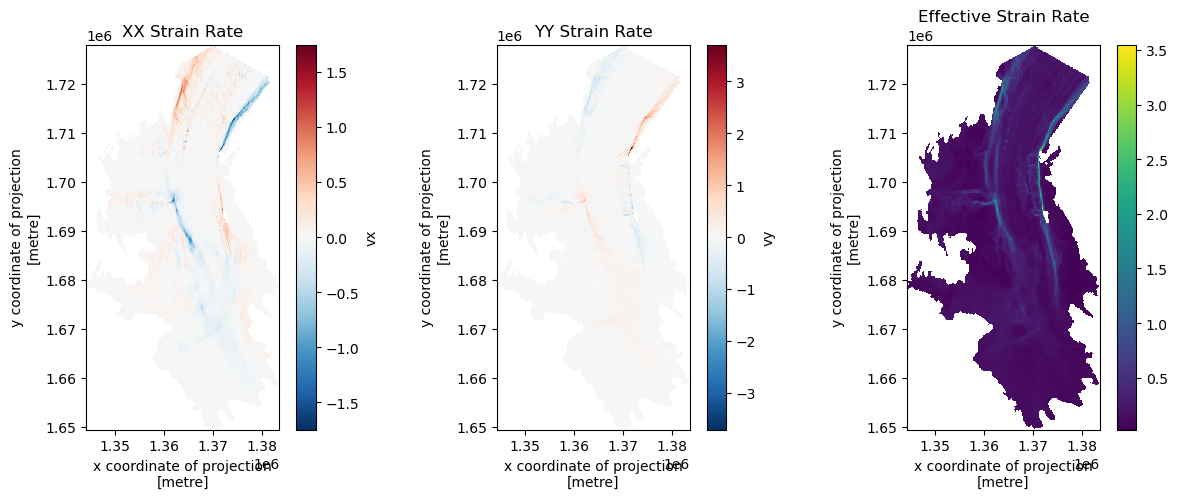

In [5]:
# create a figure with 3 columns
fig, axs = plt.subplots(ncols=3, figsize=(15,5))

# plot the temporal average of longitunal strain rates on col 1
eps_xx.mean(dim='mid_date').plot(ax=axs[0])
axs[0].set_title('XX Strain Rate')

# plot the temporal average of transverse strain rates on col 2
eps_yy.mean(dim='mid_date').plot(ax=axs[1])
axs[1].set_title('YY Strain Rate')

# plot the temporal average of effective strain rates on col 3
e_eff.mean(dim='mid_date').plot(ax=axs[2])
axs[2].set_title('Effective Strain Rate')

# set the x/y aspect to equal on each column
for ax in axs:
    ax.set_aspect('equal')

plt.show()

## Rotated Strain Rates

These maps look good, but they're a little bit simplified. The x- and y-directions here are along with the graph coordinates. The next step is to rotate the strain rates to match the direction of ice flow. The method here follows Alley et al (2018),
$$
\begin{aligned}
\dot{\epsilon}_{\text{lon}} &= \dot{\epsilon}_x \cos^2 \alpha + 2 \dot{\epsilon}_{xy} \cos \alpha \sin \alpha + \dot{\epsilon}_y \sin^2 \alpha \\
\dot{\epsilon}_{\text{trans}} &= \dot{\epsilon}_x \sin^2 \alpha - 2 \dot{\epsilon}_{xy} \cos \alpha \sin \alpha + \dot{\epsilon}_y \cos^2 \alpha \\
\dot{\epsilon}_{\text{shear}} &= (\dot{\epsilon}_y - \dot{\epsilon}_x) \cos \alpha \sin \alpha + \dot{\epsilon}_{xy} \left(\cos^2 \alpha - \sin^2 \alpha \right)
\end{aligned}
$$

Where the angle, $\alpha$ is given by $\arctan\left(\frac{v}{u}\right)$. The angle here is calculated using `np.arctan2`, and the rest of the equations are computed using `np.cos` and `np.sin` operators.

In [6]:
# Calculate the angle of rotations
alpha = np.arctan2(vy, vx)

# rotate the strain rates
eps_lon = (
    (eps_xx * (np.cos(alpha) ** 2)) + 
    (2 * eps_xy * np.cos(alpha) * np.sin(alpha)) + 
    (eps_yy * (np.sin(alpha) ** 2))
)
eps_trn = (
    (eps_xx * (np.sin(alpha) ** 2)) - 
    (2 * eps_xy * np.cos(alpha) * np.sin(alpha)) + 
    (eps_yy * (np.cos(alpha) ** 2))
)
eps_shr = (
    (eps_yy - eps_xx) * np.cos(alpha) * np.sin(alpha) + 
    eps_xy * ((np.cos(alpha) ** 2) - (np.sin(alpha) ** 2))
)

We can now and plot the values of longitudinal, transverse, and effective strain rate to get an idea of what these values look like after rotation compared to their unrotated counterparts.

Because the effective strain rate is a magnitude of the tensor components, it will not change after rotating each components and does not need to be recalculated.

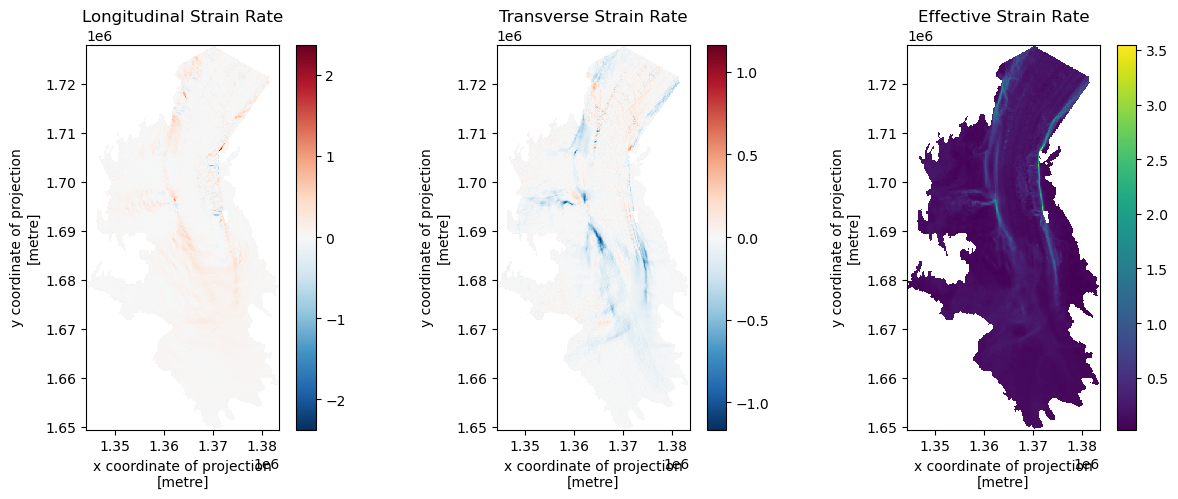

In [7]:
# create a figure with 3 columns
fig, axs = plt.subplots(ncols=3, figsize=(15,5))

# plot the temporal average of longitunal strain rates on col 1
eps_lon.mean(dim='mid_date').plot(ax=axs[0])
axs[0].set_title('Longitudinal Strain Rate')

# plot the temporal average of transverse strain rates on col 2
eps_trn.mean(dim='mid_date').plot(ax=axs[1])
axs[1].set_title('Transverse Strain Rate')

# plot the temporal average of effective strain rates on col 3
e_eff.mean(dim='mid_date').plot(ax=axs[2])
axs[2].set_title('Effective Strain Rate')

# set the x/y aspect to equal on each column
for ax in axs:
    ax.set_aspect('equal')

plt.show()

## Glen's Flow Law and Principle Stresses

Now that we have derived the strain rates, we can use Glen's Flow law to convert from the strain rate tensor to the stress tensor. Cuffey & Patterson define the Glen's Flow Law conversion as:
$$
\tau_{jk} = A^{-\left[ 1 / n \right]}\; \dot{\epsilon}_{E}^{\;\left[\left(1-n\right)/n\right]}\; \epsilon_{jk}
$$
Following guidelines from Cuffey & Patterson 2010, we set $A = 3.5\times10^{-25}$

In [8]:
# Canonical exponential value
n=3
exp = ((1 - n) / n)                   # Placeholder exponent variable
time_conversion = (365 * 24 * 3600)   # Units converter from 1/yr to 1/s
A = (3.5e-25) * time_conversion

tau_xx = (A ** (-1 / n)) * (e_eff ** exp) * eps_lon
tau_yy = (A ** (-1 / n)) * (e_eff ** exp) * eps_trn

Glen's Flow law allowed us to calculate the deviatoric stress tensor. Since ice is incompressible, the deviatoric stresses $\tau$ are not analogous with the principle stresses used in determining yeild stresses. Using the following relation, we can compute from the deviatoric stresses the principle stresses: 
$$
\sigma_1 = 2 \tau_1 + \tau_2 \\
\sigma_2 = \tau_1 + 2 \tau_2
$$

The principle stresses are then used to compute the Von Mises Stress, where:
$$
\sigma_{vm} = \sqrt{\sigma_{1}^2 + \sigma_{2}^2 - \sigma_1\sigma_2}
$$
Von Mises Stress can be interpreted as the yield stress under certain failure criterion.

In [9]:
# Convert from tau to sigma, principle stresses
# Divide by 1000 to conver to kPa
sigma1 = ((2 * tau_xx) + tau_yy) / 1000
sigma2 = (tau_xx + (2 * tau_yy)) / 1000

# Compute Von Mises Stress following Vaughan et al
sigma_vm = np.sqrt((sigma1 ** 2) + (sigma2 ** 2) - (sigma1 * sigma2))

We can now plot and visualize how the Principle and Deviatoric stresses compare. We will plot the temporal mean of each for right now.

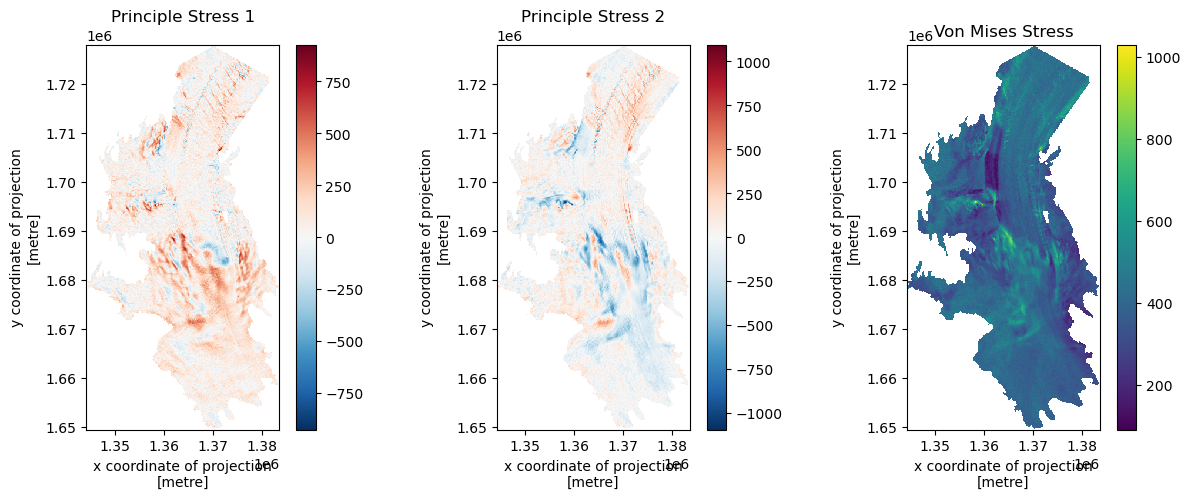

In [10]:
# Create a figure with 3 columns
fig, axs = plt.subplots(ncols=3, figsize=(15,5))

# plot temporal avg of P1 on column 1
sigma1.mean(dim='mid_date').plot(ax=axs[0])
axs[0].set_title('Principle Stress 1')

# plot temporal avg of P2 on column 2
sigma2.mean(dim='mid_date').plot(ax=axs[1])
axs[1].set_title('Principle Stress 2')

# plot temporal avg of VM stress on column 3
sigma_vm.mean(dim='mid_date').plot(ax=axs[2])
axs[2].set_title('Von Mises Stress')

# set x/y aspect to equal
for ax in axs:
    ax.set_aspect('equal')

plt.show()

## Strain Rate and Stress Function

Luckily, this process doesn't need to be written out every single time you want to derive a strain rate and subsequent stress. I have written a function `bit.compute_strain_stress` that will compute it all for you, detecting the type of array passed and computing the gradient with the appropriate method.

In [11]:
bit.compute_strain_stress?

Signature:
bit.compute_strain_stress(
    vx: xarray.core.dataarray.DataArray | numpy.ndarray,
    vy: xarray.core.dataarray.DataArray | numpy.ndarray,
    dx: int = 120,
    dy: int = 120,
    axis: tuple = (1, 2),
    rotate: bool = False,
) -> xarray.core.dataarray.DataArray | numpy.ndarray
Docstring:
Calculate the strain rate and Von Mises stress of the given velocities. 

Parameters:
-----------
vx (xr.DataArray | np.ndarray):
    velocity in the x-direction
vy (xr.DataArray | np.ndarray):
    velocity in the y-direction
dx (int, optional):
    pixel length in m. Only needs to be passed if using numpy
    Default to 120m
dy (int, optional):
    pixel length in m. Only needs to be passed if using numpy
    Default to 120m
axis (tuple, optional):
    specifies the axis to take the gradient on. Defaults to (1,2), meaning (x, y)
rotate (bool, optional):
    rotate the strain rate components to along flow, accross flow, and shear. Default to False

Returns:
--------
tuple of np.ndarray

The parameters for this function are the x and y velocities. 

If `vx` and `vy` are xarray DataArrays, these are the only required parameters. If you would like to rotate the strain rates, you can pass `rotated=True`. This function is designed for a (mid_date, y, x) dimension structure, such as the ITS_LIVE data. Passing xarray DataArrays works best because the function automatically accounts for the change in the coordinate, and does not need a dx/dy to be specified.
- Datasets pulled directly from ITS_LIVE AWS buckets with the original variable names will work perfectly with this function.

If `vx` and `vy` are numpy arrays, make sure to pass the proper parameters for dx, dy, and axis. The parameters are currently set up to run that if `vx = ds.vx.values` were passed from ITS_LIVE data, there would need to be no changes. `dx = dy = 120` is the distance step of ITS_LIVE data, `axis=(1,2)` is so that the axis for the gradient are on the x and y, not over the time axis. Adjust as needed if making changes to the data structure.
- This is not the recommended way of using this function, but is an option if you are an avid numpy user.

The function returns a list of DataArrays or numpy arrays in the following order:
- (eps_eff, eps_xx, eps_yy, sigma_vm, sigma1, sigma2)

In [12]:
# Create a list of the variable names as they will be saved
vars = ['eps_eff', 'eps_xx', 'eps_yy', 'sigma_vm', 'sigma1', 'sigma2']

# Call the function and save the variables into the original data cube
shirase_dc[vars] = bit.compute_strain_stress(shirase_dc.vx, shirase_dc.vy, rotate=True)
shirase_dc

<xarray.Dataset> Size: 750MB
Dimensions:      (mid_date: 97, y: 655, x: 328)
Coordinates:
  * x            (x) float64 3kB 1.344e+06 1.344e+06 ... 1.383e+06 1.384e+06
  * y            (y) float64 5kB 1.649e+06 1.65e+06 ... 1.728e+06 1.728e+06
    spatial_ref  int64 8B 0
    mapping      int64 8B 0
  * mid_date     (mid_date) datetime64[ns] 776B 2015-01-31 ... 2023-01-31
Data variables:
    v            (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan
    vx           (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan
    vy           (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan
    eps_eff      (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan
    eps_xx       (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan
    eps_yy       (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan
    sigma_vm     (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan
    sigma1       (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan
    sigma2       (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               26-Sep-2023 13:16:09
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/S70E030/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/S70E030/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

The function was called, and the xarray DataArrays returned were saved into the Dataset as new Data variables. Let's see how these compare to the previously derived strain rates and stresses.

In the cell below, we will take the temporal average of the dataset, then plot each of the variables.

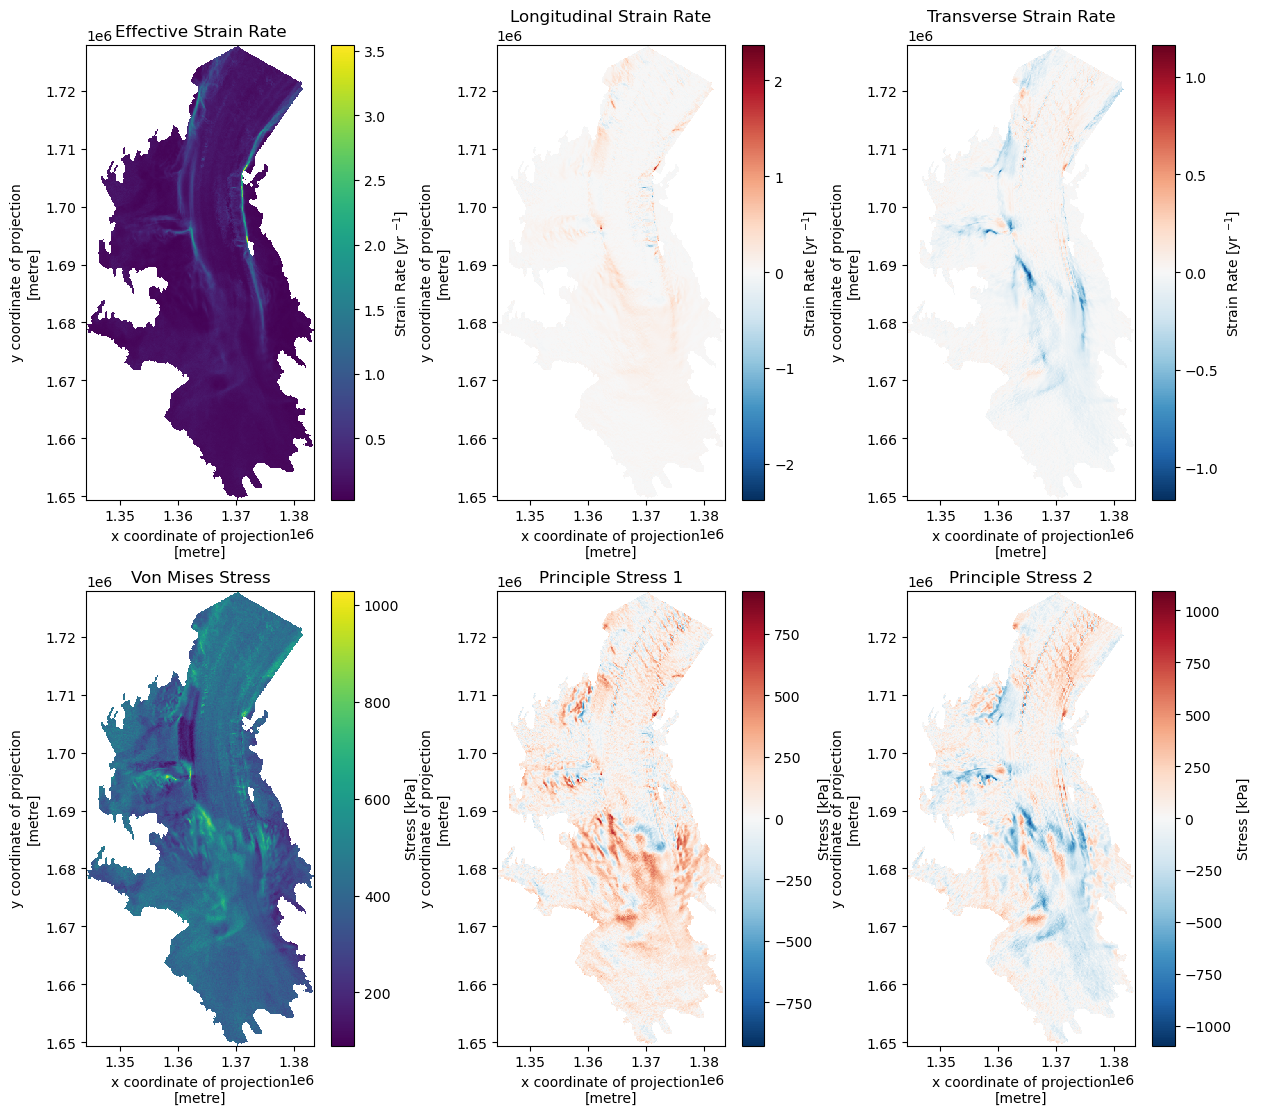

In [13]:
# Take temporal average of data in shirase dataset.
time_avg = shirase_dc.mean(dim='mid_date')
# titles for each plot
titles = [
    'Effective Strain Rate', 'Longitudinal Strain Rate', 'Transverse Strain Rate',    # Titles for first row plots
    'Von Mises Stress', 'Principle Stress 1', 'Principle Stress 2'                    # Titles for second row plots
]
# Labels for each colorbar
labels = ['Strain Rate [yr $^{-1}$]', 'Strain Rate [yr $^{-1}$]', 'Strain Rate [yr $^{-1}$]', 'Stress [kPa]', 'Stress [kPa]', 'Stress [kPa]']

# Create figure with 6 axes: 2 rows, 3 cols
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,13))
axs = axs.flatten()    # Flatten array to allow iteration

# iterate through the lists. This is a simple way to prevent copy and pasting
for ax, var, title, label in zip(axs, vars, titles, labels):
    c = time_avg[var].plot(ax=ax)
    c.colorbar.set_label(label)
    ax.set_title(title)
    ax.set_aspect('equal')

plt.subplots_adjust(wspace=.2, hspace=.2)
plt.show()

By comparing these maps with the ones we plotted earlier, we can see that they are identical. This funtion works on a monthly timescale, and computes the stresses and strain rates for each month.

This allows us to do a time-dependent analysis of the stresses over a 97 month period.

## Conclusion

You know understand how to derive strain rates and principle stresses from velocities, and understand how the function `bit.compute_stress_strain` works.

In the next notebook, we will look at these maps on a monthly timeframe and group by seasons.